In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ripple_detection.core import gaussian_smooth, get_envelope


def interpolate_to_new_time(df, new_time, upsampling_interpolation_method='linear'):
    old_time = df.index
    new_index = pd.Index(np.unique(np.concatenate(
        (old_time, new_time))), name='time')
    return (df
            .reindex(index=new_index)
            .interpolate(method=upsampling_interpolation_method)
            .reindex(index=new_time))

def get_Kay_ripple_consensus_trace(ripple_filtered_lfps, sampling_frequency,
                                   smoothing_sigma=0.004):
    ripple_consensus_trace = np.full_like(ripple_filtered_lfps, np.nan)
    not_null = np.all(pd.notnull(ripple_filtered_lfps), axis=1)

    ripple_consensus_trace[not_null] = get_envelope(
        np.asarray(ripple_filtered_lfps)[not_null])
    ripple_consensus_trace = np.sum(ripple_consensus_trace ** 2, axis=1)
    ripple_consensus_trace[not_null] = gaussian_smooth(
        ripple_consensus_trace[not_null], smoothing_sigma, sampling_frequency)
    return np.sqrt(ripple_consensus_trace)

def plot_ripple(lfps, ripple_times, ripple_label=1,  offset=0.100, relative=True):
    lfp_labels = lfps.columns
    n_lfps = len(lfp_labels)
    ripple_start = ripple_times.loc[ripple_label].start_time
    ripple_end = ripple_times.loc[ripple_label].end_time
    time_slice = slice(ripple_start - offset,
                       ripple_end + offset)
    fig, ax = plt.subplots(1, 1, figsize=(12, n_lfps * 0.20))
    
    start_offset = ripple_start if relative else 0

    for lfp_ind, lfp_label in enumerate(lfp_labels):
        lfp = lfps.loc[time_slice, lfp_label]
        ax.plot(lfp.index - start_offset, lfp_ind + (lfp - lfp.mean()) / (lfp.max() - lfp.min()),
                color='black')

    ax.axvspan(ripple_start - start_offset, ripple_end - start_offset, zorder=-1, alpha=0.5, color='lightgrey')
    ax.set_ylim((-1, n_lfps))
    ax.set_xlim((time_slice.start - start_offset, time_slice.stop - start_offset))
    ax.set_ylabel('LFPs')
    ax.set_xlabel('Time [s]')
    
    


In [164]:
from spyglass.common import (IntervalPositionInfo, IntervalPositionInfoSelection, IntervalList, 
                             ElectrodeGroup, LFP, BrainRegion, LFPBand, Electrode)
from ripple_detection import Kay_ripple_detector

nwb_file_name = 'chimi20200216_new_.nwb'
interval_list_name = 'pos 1 valid times'
position_info_param_name = 'default'
filter_name = 'Ripple 150-250 Hz'
elec_keys = (Electrode() & {'nwb_file_name': nwb_file_name}).fetch('KEY')
electrode_keys = [*elec_keys[:2], *elec_keys[6:10]]


ripple_lfp_nwb = (
    LFPBand & {'nwb_file_name': nwb_file_name,
               'filter_name': filter_name}
).fetch_nwb()[0]

ripple_lfp = pd.DataFrame(
    ripple_lfp_nwb['filtered_data'].data,
    index=pd.Index(ripple_lfp_nwb['filtered_data'].timestamps, name='time'))
sampling_frequency = ripple_lfp_nwb['lfp_band_sampling_rate']

# electrode_info = pd.DataFrame((Electrode() & {'nwb_file_name': nwb_file_name}) * BrainRegion)

# is_brain_region = ((electrode_info.probe_electrode == wire_ind) &
#                   electrode_info.region_name.isin([brain_region]))

electrode_df = (Electrode() & {'nwb_file_name': nwb_file_name}).fetch(format="frame")
electrode_keys = pd.DataFrame(electrode_keys).set_index(Electrode.primary_key).index
ripple_lfp = ripple_lfp.loc[:, electrode_df.index.isin(electrode_keys)]

position_valid_times = (
    IntervalList & {
    'nwb_file_name': nwb_file_name,
    'interval_list_name': interval_list_name}
).fetch1('valid_times')

position_info = (
    IntervalPositionInfo() &
     {'nwb_file_name': nwb_file_name,
      'interval_list_name': interval_list_name,
      'position_info_param_name': position_info_param_name}
    ).fetch1_dataframe()

position_info = pd.concat(
    [position_info.loc[slice(valid_time[0], valid_time[1])]
     for valid_time in position_valid_times], axis=1)
interval_ripple_lfps = pd.concat(
    [ripple_lfp.loc[slice(valid_time[0], valid_time[1])]
     for valid_time in position_valid_times], axis=1)

position_info = interpolate_to_new_time(position_info, interval_ripple_lfps.index)

ripple_times = Kay_ripple_detector(
    time=np.asarray(interval_ripple_lfps.index),
    filtered_lfps=np.asarray(interval_ripple_lfps),
    speed=np.asarray(position_info.head_speed),
    sampling_frequency=sampling_frequency
)

ripple_times

,start_time,end_time
ripple_number,,
1,1.581887e+09,1.581887e+09
2,1.581887e+09,1.581887e+09
3,1.581887e+09,1.581887e+09
4,1.581887e+09,1.581887e+09
5,1.581887e+09,1.581887e+09
...,...,...
144,1.581888e+09,1.581888e+09
145,1.581888e+09,1.581888e+09
146,1.581888e+09,1.581888e+09


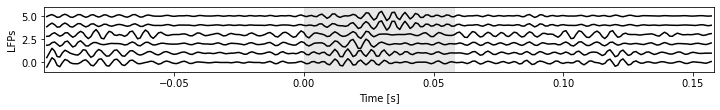

In [167]:
plot_ripple(ripple_lfp, ripple_times, ripple_label=7, relative=True)

In [162]:
ripple_consensus_trace = get_Kay_ripple_consensus_trace(
    ripple_lfp, sampling_frequency,
    smoothing_sigma=0.004)

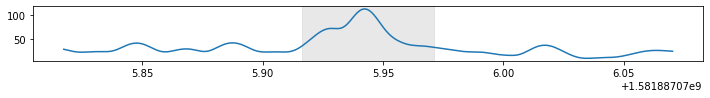

In [168]:
relative = False
ripple_label = 10

ripple_start = ripple_times.loc[ripple_label].start_time
ripple_end = ripple_times.loc[ripple_label].end_time
time_slice = slice(ripple_start - offset,
                   ripple_end + offset)

start_offset = ripple_start if relative else 0

fig, ax = plt.subplots(1, 1, figsize=(12, 1))
ax.plot(pd.DataFrame(ripple_consensus_trace, index=ripple_lfp.index).loc[time_slice])
ax.axvspan(ripple_start - start_offset, ripple_end - start_offset, zorder=-1, alpha=0.5, color='lightgrey')

In [130]:
elec_keys = (Electrode() & {'nwb_file_name': nwb_file_name}).fetch('KEY')
key_subset = [*elec_keys[:2], *elec_keys[6:10]]

In [148]:
electrode_df = (Electrode() & {'nwb_file_name': nwb_file_name}).fetch(format="frame")
ind = pd.DataFrame(key_subset).set_index(Electrode.primary_key).index
electrode_df.index.isin(ind)

array([ True,  True, False, False, False, False,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

array([ True,  True, False, False, False, False,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,